In [96]:
import os

In [97]:
%pwd

'c:\\Users\\RICH-FILES\\Desktop\\ml\\client-subscription-prediction'

In [98]:
os.chdir("../")

In [99]:
%pwd

'c:\\Users\\RICH-FILES\\Desktop\\ml'

In [100]:
proj_link = 'c:\\Users\\RICH-FILES\\Desktop\\ml\\client-subscription-prediction'
os.chdir(proj_link)

In [101]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir : Path
    test_data_path: Path
    model_path: Path
    preprocessor_path : Path
    all_params : dict
    metric_file_name: Path
    target_column: str
    mlflow_uri: str
    xgb_encoder: Path
    sm_model: Path
    rf_model: Path
    rf_processor: Path
    xgb_processor: Path
    xgb_model: Path
    
    
    
    






In [102]:
from clientClassifier.constants import *    
from clientClassifier.utils.common import read_yaml, create_directories, save_json

In [103]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath=CONFIG_FILE_PATH,
        params_filepath=PARAMS_FILE_PATH,
        schema_filepath=SCHEMA_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        
        create_directories([self.config['artifacts_root']])
        
    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config['model_evaluation']
        params = self.params['xgb_classifier']
        schema = self.schema['TARGET_COLUMN']
        
        create_directories([config['root_dir']])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir=Path(config['root_dir']),
            test_data_path=Path(config['test_data_path']),
            model_path=Path(config['model_path']),
            rf_model = Path(config['rf_model']),
            rf_processor  = Path(config['rf_processor']),
            preprocessor_path = Path(config['preprocessor_path']),
            xgb_encoder= Path(config['xgb_encoder']),
            xgb_model= Path(config['xgb_model']),   
            sm_model = Path(config['sm_model']),
            xgb_processor = Path(config['xgb_processor']),  
            all_params=params,
            metric_file_name=Path(config['metric_file_name']),
            target_column=schema.name,
            mlflow_uri="https://dagshub.com/richardmukechiwa/client-subscription-prediction.mlflow"
        )
        
        return model_evaluation_config
                
          

In [ ]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from urllib.parse import urlparse
import joblib
import mlflow 
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import shap
from clientClassifier import logger
import numpy as np
import optuna







In [ ]:
class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config

    def eval_metrics(self, actual, pred):
        accuracy = accuracy_score(actual, pred)
        precision = precision_score(actual, pred, average='weighted')
        recall = recall_score(actual, pred, average='weighted')
        f1 = f1_score(actual, pred, average='weighted')
        return accuracy, precision, recall, f1

    def log_confusion_matrix(self, actual, predicted, class_names):
        cm = confusion_matrix(actual, predicted)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")

        temp_img_path = tempfile.NamedTemporaryFile(suffix=".png", delete=False).name
        plt.savefig(temp_img_path)
        plt.close()

        mlflow.log_artifact(temp_img_path, artifact_path="confusion_matrix")

    def log_classification_report(self, actual, predicted, class_names):
        report = classification_report(actual, predicted, target_names=class_names)
        temp_txt_path = tempfile.NamedTemporaryFile(suffix=".txt", delete=False).name
        with open(temp_txt_path, "w") as f:
            f.write(report)
        mlflow.log_artifact(temp_txt_path, artifact_path="xgb_classification_report")

    def log_into_mlflow(self):
        test_data = pd.read_csv(self.config.test_data_path)
        
        model = joblib.load(self.config.xgb_model)
        processor = joblib.load(self.config.xgb_processor)
        encoder = joblib.load(self.config.xgb_encoder)
    

        test_x = test_data.drop(self.config.target_column, axis=1)
        test_y = test_data[self.config.target_column]
        
        #label encoding the target variable
        test_y = encoder.transform(test_y)
        

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        
        mlflow.set_experiment("classification_with_xgbclassifier_artifacts_stored")
        

        if mlflow.active_run():
            mlflow.end_run()

        with mlflow.start_run():
            #processing = model.transform(test_x)
            processed = processor.transform(test_x)
            predicted_qualities = model.predict(processed)
            
            
            

            accuracy, precision, recall, f1 = self.eval_metrics(test_y, predicted_qualities)

            model_name = "xgb_classifier" 

            scores = {
                "model_name": model_name,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            }

            save_json(path=Path(self.config.metric_file_name), data=scores)

            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1_score", f1)

            class_names =encoder.classes_
            self.log_confusion_matrix(test_y, predicted_qualities, class_names)
            self.log_classification_report(test_y, predicted_qualities, class_names)

            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(model, "model", registered_model_name="XGB ClassificationModel")
            else:
                mlflow.sklearn.log_model(model, "model")




    def feature_importance(self):
        
        test_data = pd.read_csv(self.config.test_data_path)
        
      
        
        model = joblib.load(self.config.xgb_model)
        processor = joblib.load(self.config.xgb_processor)
        
        test_x = test_data.drop(self.config.target_column, axis=1)
        
        processed = processor.transform(test_x)
        
        # getting the feature names from the processor
        feature_names = processor.get_feature_names_out()
        # Convert the processed data back to a DataFrame with feature names
        processed = pd.DataFrame(processed, columns=feature_names)              
        
        # Create SHAP explainer
        explainer = shap.TreeExplainer(model)

        # Use evaluation/test set ideally
        shap_values = explainer.shap_values(processed)

        # Plot SHAP summary
        shap.summary_plot(shap_values, processed)
        
        
        #findings of the shap summary plot
        
        logger.info("The SHAP analysis revealed that the top five features driving model predictions are:")
        print("  " * 50)
        logger.info("1. Previous Campaign Outcome (cat__poutcome_success): Clients who previously responded positively to campaigns are much more likely to subscribe again.")
        print(" " * 50)
        logger.info("2. Account Balance (num__balance): Clients with higher account balances are significantly more likely to subscribe.") 
        print(" " * 50)
        logger.info("3. Day of Contact (num__day): The specific day of the month when a client is contacted strongly influences the outcome.")
        print(" " * 50)
        logger.info("4. Month of Contact (num__month): Seasonality effects are evident, with specific months (e.g., holiday or bonus periods) boosting subscription likelihood.")
        print(" " * 50)
        logger.info("5. Age of Client (num__age): Age plays a significant role, with different age groups showing distinct patterns in subscription behavior.")                 

       
       
            
          
        
                               

[2025-04-26 22:29:12,567: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-04-26 22:29:12,573: INFO: common: yaml file: params.yaml loaded successfully]
[2025-04-26 22:29:12,578: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-04-26 22:29:12,581: INFO: common: created directory at: artifacts]
[2025-04-26 22:29:12,583: INFO: common: created directory at: artifacts/model_evaluation]


[2025-04-26 22:29:12,692: INFO: common: json file saved at: artifacts\model_evaluation\metrics.json]


2025/04/26 22:29:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


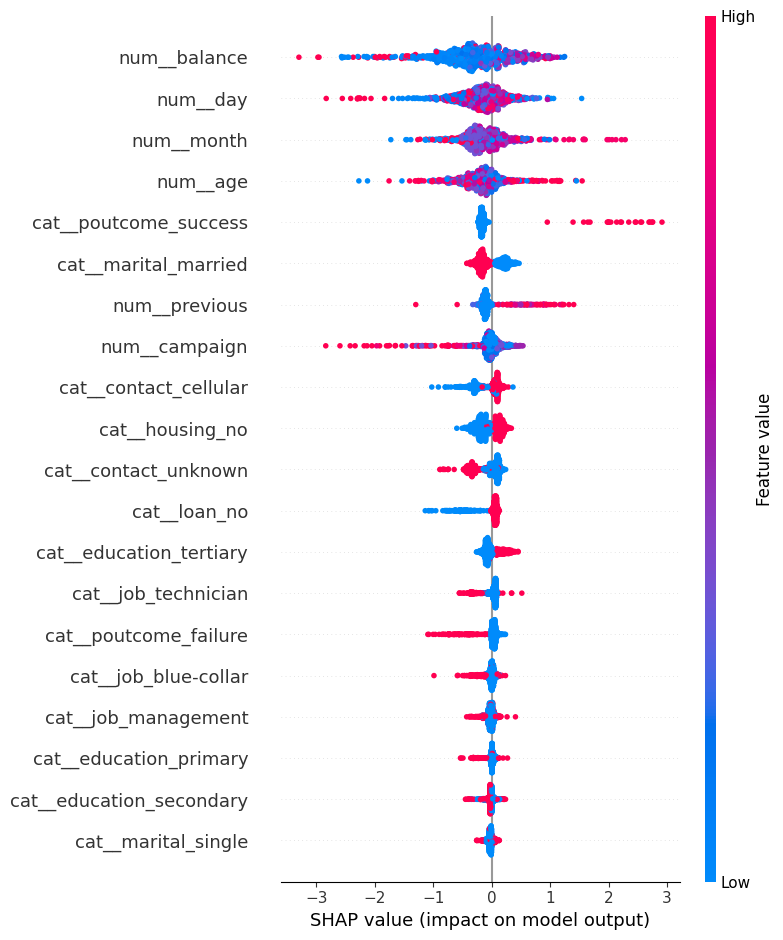

[2025-04-26 22:29:17,945: INFO: 3701005408: The SHAP analysis revealed that the top five features driving model predictions are:]
                                                                                                    
[2025-04-26 22:29:17,947: INFO: 3701005408: 1. Previous Campaign Outcome (cat__poutcome_success): Clients who previously responded positively to campaigns are much more likely to subscribe again.]
                                                  
[2025-04-26 22:29:17,947: INFO: 3701005408: 2. Account Balance (num__balance): Clients with higher account balances are significantly more likely to subscribe.]
                                                  
[2025-04-26 22:29:17,948: INFO: 3701005408: 3. Day of Contact (num__day): The specific day of the month when a client is contacted strongly influences the outcome.]
                                                  
[2025-04-26 22:29:17,950: INFO: 3701005408: 4. Month of Contact (num__month): Seasonality eff

In [106]:

try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation = ModelEvaluation(config=model_evaluation_config)  # Initialize model_evaluation
    model_evaluation.log_into_mlflow()
    model_evaluation.feature_importance()
 
except Exception as e:
    raise e